In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer
import time
from matplotlib import pyplot as plt

In [16]:
class FBSNN(): # Forward-Backward Stochastic Neural Network
    def __init__(self, layers, Xi, T,
                       M, N, D):
        '''
        layers: list of number of neurons in each layer
        layers[1] is the input layer
        layers[-1] is the output layer normally 1
        '''
        # initial point
        self.Xi = Xi
        # terminal time
        self.T = T
        # number of trajectories
        self.M = M
        # number of time snapshots
        self.N = N
        # number of dimensions
        self.D = D

        # layers eg [100, 256, 256, 256, 256, 1]
        layers[0] = D+1
        self.layers = layers
        model = tf.keras.Sequential()
        for layer in layers[:-1]:
            model.add(Dense(layer, activation=None, kernel_initializer='glorot_normal', bias_initializer='zeros'))
            model.add(SinActivation())
        model.add(Dense(layers[-1]))
        self.model = model

    def call(self, inputs):
        return self.model(inputs)

    def optimizer(self, learning_rate):
        # return tf.keras.optimizers.legacy.Adam(learning_rate)
        return tf.keras.optimizers.Adam(learning_rate)

    def net_u(self, t, X): # M x 1, M x D
        with tf.GradientTape() as tape:
            tape.watch(X)
            u = self.model(tf.concat([t,X],1)) # M x 1
            Du = tape.gradient(u, X)[0] # M x D
        return u, Du

    def Dg_tf(self, X): # M x D
        with tf.GradientTape() as tape:
            tape.watch(X)
            return tape.gradient(self.g_tf(X), X)[0]

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D
        t = tf.convert_to_tensor(t, dtype=tf.float32)
        W = tf.convert_to_tensor(W, dtype=tf.float32)

        return t, W

    def loss_function(self, t, W, Xi):
        X = Xi + W
        loss = 0
        X_list = []
        Y_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Z0 = self.net_u(t0,X0) # M x 1, M x D

        X_list.append(X0)
        Y_list.append(Y0)

        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
            Y1, Z1 = self.net_u(t1,X1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        loss += tf.reduce_sum(tf.square(Z1 - self.Dg_tf(X1)))
        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)

        return loss, X, Y, Y[0,0,0]

    def train(self, N_Iter, learning_rate):
        optimizer = self.optimizer(learning_rate)
        start_time = time.time()
        loss_list = []
        for it in range(N_Iter):
            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D
            with tf.GradientTape() as tape:
                loss, X, Y, Y0 = self.loss_function(t_batch, W_batch, self.Xi)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            elapsed = time.time() - start_time
            print(f'Epoch {it+1}/{N_Iter}, Loss: {loss.numpy()}, Time: {elapsed}')
            loss_list.append(loss.numpy())
            start_time = time.time()
        plt.plot(loss_list)
        plt.show()

    def predict(self, Xi_star, t_star, W_star):
        X_star = Xi_star + W_star
        Y_star = self.model(tf.concat([t_star, X_star], 2))
        return X_star.numpy(), Y_star.numpy()

    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        return - Y + Y**3 # M x 1

    def g_tf(self, X):
        return 1.0/(2.0 + 0.4*tf.reduce_sum(X**2, 1, keepdims = True))

    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.linalg.diag(tf.ones([M,D])) # M x D x D



class SinActivation(Layer):
    def __init__(self):
        super(SinActivation, self).__init__()

    def call(self, inputs):
        return tf.math.sin(inputs)

Epoch 1/20000, Loss: 11.887205123901367, Time: 0.44507265090942383
Epoch 2/20000, Loss: 37.566871643066406, Time: 0.29102134704589844
Epoch 3/20000, Loss: 5.773776531219482, Time: 0.30261850357055664
Epoch 4/20000, Loss: 9.074031829833984, Time: 0.3072075843811035
Epoch 5/20000, Loss: 11.23554801940918, Time: 0.2993960380554199
Epoch 6/20000, Loss: 6.448762893676758, Time: 0.32175731658935547
Epoch 7/20000, Loss: 3.0849547386169434, Time: 0.30556678771972656
Epoch 8/20000, Loss: 2.648866653442383, Time: 0.3001708984375
Epoch 9/20000, Loss: 2.9396708011627197, Time: 0.33316707611083984
Epoch 10/20000, Loss: 4.272156715393066, Time: 0.30431604385375977
Epoch 11/20000, Loss: 2.4162471294403076, Time: 0.2940964698791504
Epoch 12/20000, Loss: 2.3128550052642822, Time: 0.2904388904571533
Epoch 13/20000, Loss: 1.5335689783096313, Time: 0.28456544876098633
Epoch 14/20000, Loss: 1.113715410232544, Time: 0.27457642555236816
Epoch 15/20000, Loss: 0.8015705943107605, Time: 0.2767012119293213
Epoch

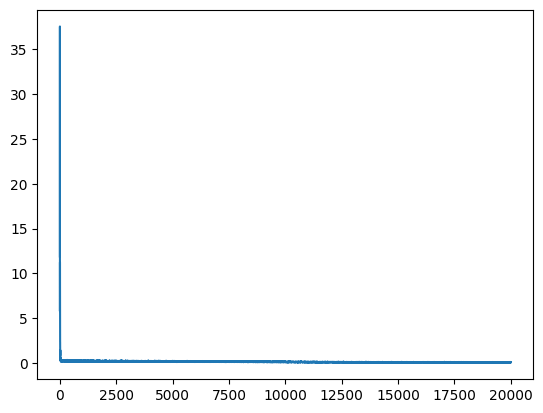

In [17]:
M = 100  # number of trajectories (batch size)
N = 15  # number of time snapshots
D = 20  # number of dimensions
T = 0.3
Xi = np.zeros([1, D])
Xi = tf.convert_to_tensor(Xi, dtype=tf.float32)
layers = [100, 256, 256, 256, 256, 1]

model = FBSNN(layers, Xi, T, M, N, D)
model.train(N_Iter = 20000, learning_rate=1e-3)

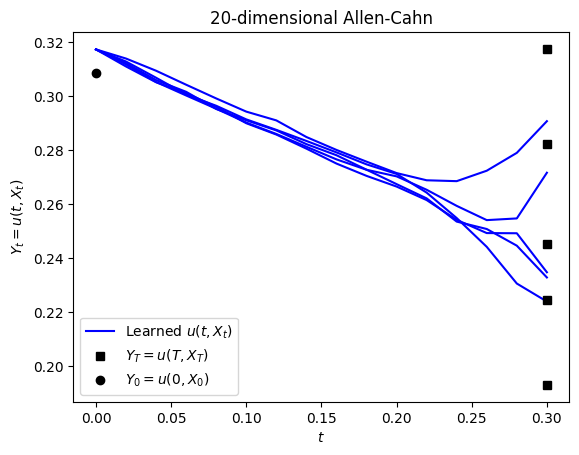

In [21]:
t_test, W_test = model.fetch_minibatch()

X_pred, Y_pred = model.predict(Xi, t_test, W_test)

samples = 5

Y_test_terminal = 1.0 / (2.0 + 0.4 * np.sum(X_pred[:, -1, :] ** 2, 1, keepdims=True))

plt.figure()
plt.plot(t_test[0, :, 0].numpy().T, Y_pred[0, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[1:samples, :, 0].numpy().T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[0:samples, -1, 0], Y_test_terminal[0:samples, 0], 'ks', label='$Y_T = u(T,X_T)$')
plt.plot([0], [0.30879], 'ko', label='$Y_0 = u(0,X_0)$')
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('20-dimensional Allen-Cahn')
plt.legend()

In [23]:
model.layers

[21, 256, 256, 256, 256, 1]